In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam

class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
                                                      activation='relu')
        self.shared_dense_two = tf.keras.layers.Dense(self.channel)

        self.conv_spatial = tf.keras.layers.Conv2D(filters=1,
                                                   kernel_size=7,
                                                   padding='same',
                                                   activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = inputs * scale

        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        scale = self.conv_spatial(concat)
        x = x * scale
        return x

Model_Input=Input(shape=(1024,768,3))
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(1024, 768,3))

conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_conv3').output)

conv_base.summary()

x = conv_base(Model_Input)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024, 768, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 1024, 768, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 1024, 768, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 512, 384, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 512, 384, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 512, 384, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 256, 192, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 256, 192, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 256, 192, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 256, 192, 256)  │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
a1=Conv2D(512,3,padding='same',activation='relu')(x)
a2=Conv2D(256,3,padding='same',activation='relu')(a1)
a3=Conv2D(128,3,padding='same',activation='relu')(a2)
a4=Conv2D(64,3,padding='same',activation='relu')(a3)

b1=Conv2D(512,3,padding='same',activation='relu',dilation_rate=2)(x)
b2=Conv2D(256,3,padding='same',activation='relu',dilation_rate=2)(b1)
b3=Conv2D(128,3,padding='same',activation='relu',dilation_rate=2)(b2)
b4=Conv2D(64,3,padding='same',activation='relu',dilation_rate=2)(b3)

c1=Conv2D(512,3,padding='same',activation='relu',dilation_rate=3)(x)
c2=Conv2D(256,3,padding='same',activation='relu',dilation_rate=3)(c1)
c3=Conv2D(128,3,padding='same',activation='relu',dilation_rate=3)(c2)
c4=Conv2D(64,3,padding='same',activation='relu',dilation_rate=3)(c3)

merged_ouput=concatenate([a4,b4,c4])
d1=CBAMLayer()(merged_ouput)
e1=Conv2D(1,1)(d1)

model=Model(inputs=Model_Input,outputs=e1)

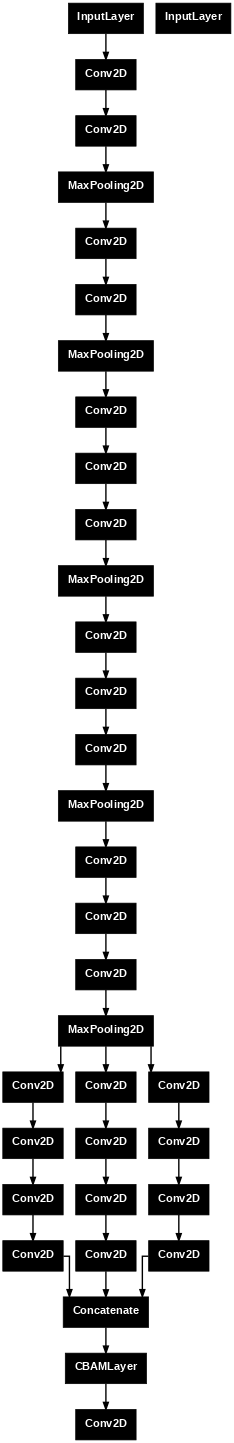

In [ ]:
from keras.utils import plot_model
plot_model(model,dpi=50)

In [ ]:
total_absolute_error = 0
total_samples = 0

for file in test_files:
    image_path = os.path.join(test_image_dir, file)
    gt_path = os.path.join(test_gt_dir, "GT_" + file.replace(".jpg", ".mat"))
    
    test_image = preprocess_image(image_path)
    
    predicted_density = model.predict(test_image)
    predicted_density = np.squeeze(predicted_density)
    predicted_count = predicted_density.sum()
    
    points = load_ground_truth(gt_path)
    gt_count = len(points)
    
    error = abs(predicted_count - gt_count)
    total_absolute_error += error
    total_samples += 1
    
    print(f"Image: {file}")
    print(f"Predicted Count: {predicted_count:.2f}")
    print(f"Ground Truth Count: {gt_count}")
    print(f"Absolute Error: {error:.2f}\n")

mae = total_absolute_error / total_samples
print(f"Mean Absolute Error on test set: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Image: IMG_1.jpg
Predicted Count: 48.42
Ground Truth Count: 23
Absolute Error: 25.42

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Image: IMG_10.jpg
Predicted Count: 98.50
Ground Truth Count: 181
Absolute Error: 82.50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Image: IMG_100.jpg
Predicted Count: 139.45
Ground Truth Count: 158
Absolute Error: 18.55

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Image: IMG_101.jpg
Predicted Count: 0.94
Ground Truth Count: 37
Absolute Error: 36.06

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Image: IMG_102.jpg
Predicted Count: 75.82
Ground Truth Count: 70
Absolute Error: 5.82

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Image: IMG_103.jpg
Predicted Count: 153.30
Ground Truth Count: 57
Absolute Error: 96.30

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Image: IMG_104.jpg
Predicted Count: 223.02
Ground Truth Count: 44
Absolute Error: 179.02

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Image: IMG_105.jpg
Predicted Count: 136.94
Ground Truth Count: 228
Abso